# TDT4173 Modern Machine Learning - Hydro Raw Material Forecasting

## Project Information
- **Students**: Marco Prosperi, Andrea Richichi, Gianluigi Vazzoler
- **Student IDs**: 151613, 151790, 152698
- **Kaggle Team**: [66] AMG

## Project Overview
This notebook implements a **Multi-Period Estimation (MPE)** approach with recursive forecasting to predict raw material receivals for Hydro's manufacturing process. The model is optimized for the **Quantile Error metric (q=0.2)**, which penalizes overestimation more heavily than underestimation.

## Key Features
- **Recursive forecasting**: Day-by-day predictions that update lag features dynamically
- **Adaptive shrinkage**: RM-specific conservative adjustments based on historical behavior
- **No data leakage**: Rolling features computed only on historical data
- **Active material filtering**: Focuses on materials with recent activity or future purchase orders

In [ ]:
# ============================================================================
# SECTION 1: IMPORTS AND CONFIGURATION
# ============================================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.base import clone
import io
import warnings
from datetime import datetime, timedelta
import re
import gc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

print("=" * 80)
print("HYDRO RAW MATERIAL FORECASTING - MPE APPROACH WITH RECURSIVE FORECASTING")
print("=" * 80)

# ============================================================================
# SECTION 2: EVALUATION METRIC DEFINITION
# ============================================================================

print("\n[1/9] Defining evaluation metric...")

def quantile_error(y_true, y_pred, q=0.2):
    """
    Calculate Quantile Error metric.
    
    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
    q : float
        Quantile parameter (0.2 penalizes overestimation more heavily)
    
    Returns:
    --------
    float : Quantile error score (lower is better)
    """
    error = y_true - y_pred
    return np.mean(np.maximum(q * error, (q - 1) * error))

print("✓ Quantile Error metric defined (q=0.2)")

# ============================================================================
# SECTION 3: DATA LOADING
# ============================================================================

print("\n[2/9] Loading datasets...")

# Load core datasets
df_receivals = pd.read_csv("../data/kernel/receivals.csv")
df_po = pd.read_csv("../data/kernel/purchase_orders.csv")
df_materials = pd.read_csv("../data/extended/materials.csv")
df_mapping = pd.read_csv("../data/prediction_mapping.csv")

print(f"✓ Loaded {len(df_receivals):,} receival records")
print(f"✓ Loaded {len(df_po):,} purchase order records")
print(f"✓ Loaded {len(df_materials):,} material mappings")
print(f"✓ Loaded {len(df_mapping):,} prediction targets")

# ============================================================================
# SECTION 4: DATA PREPROCESSING
# ============================================================================

print("\n[3/9] Preprocessing data...")

# 4.1 Clean receivals data
df_receivals['date'] = pd.to_datetime(df_receivals['date_arrival'], utc=True, errors='coerce').dt.tz_localize(None).dt.normalize()
df_receivals = df_receivals.dropna(subset=['date', 'rm_id', 'net_weight'])
df_receivals = df_receivals[df_receivals['net_weight'] > 0]

# Define temporal boundaries
pred_start_date_dt = datetime.strptime('2025-01-01', '%Y-%m-%d')
pred_end_date_dt = datetime.strptime('2025-05-31', '%Y-%m-%d')
end_of_2024 = datetime.strptime('2024-12-31', '%Y-%m-%d')

# Filter historical data (before prediction period)
df_receivals_hist = df_receivals[df_receivals['date'] < pred_start_date_dt].copy()
df_receivals_hist['rm_id'] = df_receivals_hist['rm_id'].astype(int)

# Aggregate to daily level by rm_id
df_daily_target = df_receivals_hist.groupby(['rm_id', 'date'])['net_weight'].sum().reset_index()

print(f"✓ Cleaned to {len(df_daily_target):,} daily records")
print(f"✓ Date range: {df_receivals_hist['date'].min()} to {df_receivals_hist['date'].max()}")

# 4.2 Prepare purchase orders with correct splitting
print("  - Processing purchase orders with product-to-RM mapping...")

# Map products to raw materials (some products split into multiple RMs)
df_mat_map = df_materials[['product_id', 'rm_id']].drop_duplicates().dropna()
df_split_count = df_mat_map.groupby('product_id')['rm_id'].nunique().reset_index(name='n_splits')
df_mat_map = pd.merge(df_mat_map, df_split_count, on='product_id', how='left')

# Merge PO with material mapping
df_po_merged = pd.merge(df_po, df_mat_map, on='product_id', how='left')
df_po_merged = df_po_merged.dropna(subset=['rm_id', 'n_splits'])
df_po_merged['rm_id'] = df_po_merged['rm_id'].astype(int)
df_po_merged['date'] = pd.to_datetime(df_po_merged['delivery_date'], utc=True, errors='coerce').dt.tz_localize(None).dt.normalize()
df_po_merged = df_po_merged[df_po_merged['quantity'] > 0]
df_po_merged = df_po_merged.dropna(subset=['date'])

# Split quantities across multiple RMs if needed
df_po_merged['quantity_split'] = df_po_merged['quantity'] / df_po_merged['n_splits']

# Aggregate PO by rm_id and date
df_po_agg = df_po_merged.groupby(['rm_id', 'date'])['quantity_split'].sum().reset_index()
df_po_agg.rename(columns={'quantity_split': 'po_agg_qty_split'}, inplace=True)

print(f"✓ Processed {len(df_po_agg):,} daily PO records")

# ============================================================================
# SECTION 5: ACTIVE MATERIAL FILTERING
# ============================================================================

print("\n[4/9] Identifying active materials (heuristic filter)...")

# Define materials as "active" if they meet either criterion:
# 1. Had receivals after 2023-01-01 (recent activity)
# 2. Have purchase orders in the forecast period (future activity expected)

RECENT_DATE_CUTOFF = datetime.strptime('2023-01-01', '%Y-%m-%d')

rm_ids_recent_receivals = df_daily_target[df_daily_target['date'] >= RECENT_DATE_CUTOFF]['rm_id'].unique()
rm_ids_future_po = df_po_agg[df_po_agg['date'] >= pred_start_date_dt]['rm_id'].unique()
active_rm_ids = np.union1d(rm_ids_recent_receivals, rm_ids_future_po)

print(f"✓ Identified {len(active_rm_ids):,} active materials")
print(f"  - {len(rm_ids_recent_receivals):,} with recent receivals (since 2023)")
print(f"  - {len(rm_ids_future_po):,} with future purchase orders")

# ============================================================================
# SECTION 6: FEATURE ENGINEERING
# ============================================================================

print("\n[5/9] Building feature matrix...")

# 6.1 Create complete date grid for historical period (active materials only)
min_date_hist = df_daily_target['date'].min() if not df_daily_target.empty else datetime.strptime('2022-01-01', '%Y-%m-%d')
all_dates_hist = pd.date_range(start=min_date_hist, end=end_of_2024, freq='D')

df_grid_hist_mpe = pd.MultiIndex.from_product([active_rm_ids, all_dates_hist], names=['rm_id', 'date'])
df_grid_hist_mpe = pd.DataFrame(index=df_grid_hist_mpe).reset_index()
df_grid_hist_mpe['rm_id'] = df_grid_hist_mpe['rm_id'].astype(int)

# Merge with actual receivals (fill missing days with 0)
df_train_full_mpe = pd.merge(df_grid_hist_mpe, df_daily_target, on=['rm_id', 'date'], how='left')
df_train_full_mpe['net_weight'] = df_train_full_mpe['net_weight'].fillna(0)

# 6.2 Create future date grid for prediction period
all_dates_pred = pd.date_range(start=pred_start_date_dt, end=pred_end_date_dt, freq='D')
df_grid_pred_mpe = pd.MultiIndex.from_product([active_rm_ids, all_dates_pred], names=['rm_id', 'date'])
df_grid_pred_mpe = pd.DataFrame(index=df_grid_pred_mpe).reset_index()
df_grid_pred_mpe['rm_id'] = df_grid_pred_mpe['rm_id'].astype(int)

# Combine historical and future into master dataframe
df_master_mpe = pd.concat([df_train_full_mpe, df_grid_pred_mpe], ignore_index=True)
df_master_mpe['date'] = pd.to_datetime(df_master_mpe['date'])
df_master_mpe.sort_values(by=['rm_id', 'date'], inplace=True)

print(f"✓ Created master dataframe: {len(df_master_mpe):,} rows")

# 6.3 Merge purchase order features
df_master_mpe = pd.merge(df_master_mpe, df_po_agg, on=['rm_id', 'date'], how='left')
df_master_mpe['po_agg_qty_split'] = df_master_mpe['po_agg_qty_split'].fillna(0)
df_master_mpe.rename(columns={'po_agg_qty_split': 'po_expected_quantity'}, inplace=True)

# 6.4 Create temporal features
df_master_mpe['dayofweek'] = df_master_mpe['date'].dt.dayofweek
df_master_mpe['month'] = df_master_mpe['date'].dt.month
df_master_mpe['dayofyear'] = df_master_mpe['date'].dt.dayofyear
df_master_mpe['year'] = df_master_mpe['date'].dt.year
df_master_mpe['weekofyear'] = df_master_mpe['date'].dt.isocalendar().week.astype(int)
df_master_mpe['is_weekend'] = (df_master_mpe['dayofweek'] >= 5).astype(int)

# 6.5 Create PO rolling features (excluded from training to avoid leakage)
df_master_mpe['po_roll_mean_7'] = df_master_mpe.groupby('rm_id')['po_expected_quantity'].transform(lambda x: x.rolling(7, 1).mean())
df_master_mpe['po_roll_sum_7'] = df_master_mpe.groupby('rm_id')['po_expected_quantity'].transform(lambda x: x.rolling(7, 1).sum())

# 6.6 Create lag features
LAGS_MPE = [7, 14, 28, 30, 91, 182, 270, 364]
for lag in LAGS_MPE:
    df_master_mpe[f'lag_{lag}'] = df_master_mpe.groupby('rm_id')['net_weight'].shift(lag)

print(f"✓ Created {len(LAGS_MPE)} lag features: {LAGS_MPE}")

# 6.7 Create rolling features (ONLY on historical data to prevent leakage)
print("  - Computing rolling features on historical data only...")

df_hist_only = df_master_mpe[df_master_mpe['date'] < pred_start_date_dt].copy()

# Rolling aggregations of lag features
df_hist_only['lag_7_roll_mean_14'] = df_hist_only.groupby('rm_id')['lag_7'].transform(lambda x: x.rolling(14, 7).mean())
df_hist_only['lag_364_roll_mean_7'] = df_hist_only.groupby('rm_id')['lag_364'].transform(lambda x: x.rolling(7, 1).mean())
df_hist_only['lag_30_roll_mean_90'] = df_hist_only.groupby('rm_id')['lag_30'].transform(lambda x: x.rolling(90, 30).mean())

# Merge back into master (future dates will have NaN, populated during recursive forecasting)
df_master_mpe = pd.merge(
    df_master_mpe,
    df_hist_only[['rm_id', 'date', 'lag_7_roll_mean_14', 'lag_364_roll_mean_7', 'lag_30_roll_mean_90']],
    on=['rm_id', 'date'],
    how='left'
)

# 6.8 Define final feature set (exclude target, identifiers, and PO features)
mpe_features = [col for col in df_master_mpe.columns if col not in ['net_weight', 'date', 'rm_id'] and 'po_' not in col]
categorical_features_mpe = ['dayofweek', 'month', 'weekofyear', 'is_weekend']
categorical_features_mpe = [col for col in categorical_features_mpe if col in mpe_features]

print(f"✓ Final feature set: {len(mpe_features)} features")
print(f"  - Categorical: {categorical_features_mpe}")
print(f"  - Note: PO features excluded to prevent data leakage")

print("\n" + "=" * 80)

HYDRO RAW MATERIAL FORECASTING - MPE APPROACH WITH RECURSIVE FORECASTING

[1/9] Defining evaluation metric...
✓ Quantile Error metric defined (q=0.2)

[2/9] Loading datasets...
✓ Loaded 122,590 receival records
✓ Loaded 33,171 purchase order records
✓ Loaded 1,218 material mappings
✓ Loaded 30,450 prediction targets

[3/9] Preprocessing data...
✓ Cleaned to 41,906 daily records
✓ Date range: 2004-06-15 00:00:00 to 2024-12-19 00:00:00
  - Processing purchase orders with product-to-RM mapping...
✓ Processed 43,996 daily PO records

[4/9] Identifying active materials (heuristic filter)...
✓ Identified 121 active materials
  - 72 with recent receivals (since 2023)
  - 92 with future purchase orders

[5/9] Building feature matrix...
✓ Created master dataframe: 926,376 rows
✓ Created 8 lag features: [7, 14, 28, 30, 91, 182, 270, 364]
  - Computing rolling features on historical data only...
✓ Final feature set: 17 features
  - Categorical: ['dayofweek', 'month', 'weekofyear', 'is_weekend']
 

# Exploratory Data Analysis (EDA)

This section provides a comprehensive analysis of the historical receival data and purchase orders to understand:
- **Temporal patterns**: How receivals fluctuate over time
- **Material distribution**: Which materials are most active and their variability
- **Purchase order signals**: Expected future activity based on PO data

These insights inform our modeling strategy and help validate prediction reasonableness.


EDA 1: TEMPORAL ANALYSIS OF RECEIVALS

Monthly receival statistics (last 12 months):
    year_month        sum  count          mean
235 2024-01-01  6259731.0    419  14939.692124
236 2024-02-01  7636180.0    527  14489.905123
237 2024-03-01  7488263.0    528  14182.316288
238 2024-04-01  8292153.0    584  14198.892123
239 2024-05-01  7866102.0    532  14785.906015
240 2024-06-01  8103896.0    580  13972.234483
241 2024-07-01  9933957.0    711  13971.810127
242 2024-08-01  2371302.0    157  15103.834395
243 2024-09-01  8291029.0    564  14700.406028
244 2024-10-01  8484771.0    620  13685.114516
245 2024-11-01  6966989.0    462  15080.062771
246 2024-12-01  4406740.0    312  14124.166667

✓ Chart saved: 'eda_temporal_analysis.png'


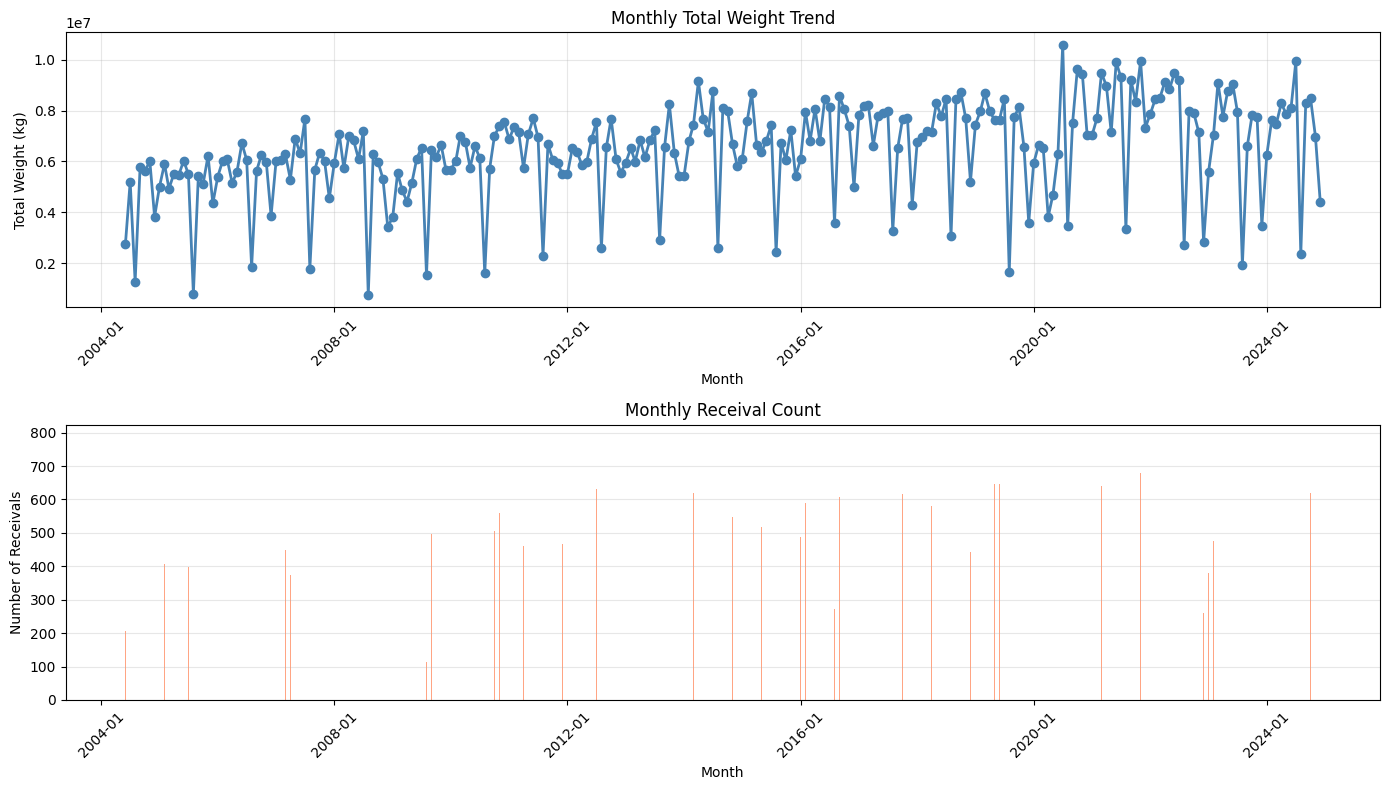

In [ ]:
# ============================================================================
# EDA 1: TEMPORAL ANALYSIS OF RECEIVALS
# ============================================================================

print("\n" + "=" * 80)
print("EDA 1: TEMPORAL ANALYSIS OF RECEIVALS")
print("=" * 80)

# Aggregate receivals by month
df_receivals['year_month'] = df_receivals['date'].dt.to_period('M')
df_monthly = df_receivals.groupby('year_month')['net_weight'].agg(['sum', 'count', 'mean']).reset_index()
df_monthly['year_month'] = df_monthly['year_month'].dt.to_timestamp()

print("\nMonthly receival statistics (last 12 months):")
print(df_monthly.tail(12).to_string())

# Visualize temporal trends
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Total monthly weight
axes[0].plot(df_monthly['year_month'], df_monthly['sum'], marker='o', color='steelblue', linewidth=2)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Weight (kg)')
axes[0].set_title('Monthly Total Weight Trend')
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Number of monthly receivals
axes[1].bar(df_monthly['year_month'], df_monthly['count'], color='coral', alpha=0.7)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Receivals')
axes[1].set_title('Monthly Receival Count')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('eda_temporal_analysis.png', dpi=150, bbox_inches='tight')
print("\n✓ Chart saved: 'eda_temporal_analysis.png'")
plt.show()

print("=" * 80)


EDA 2: MATERIAL DISTRIBUTION ANALYSIS

Total unique materials: 203

Descriptive statistics by material:
       total_weight  num_receivals    avg_weight          cv
count  2.030000e+02     203.000000    203.000000  178.000000
mean   7.829471e+06     602.871921  13725.562330    0.530622
std    3.473297e+07    2426.842614   8118.060462    0.405568
min    1.780000e+03       1.000000    597.350000    0.000000
25%    3.066500e+04       3.500000   6850.490794    0.184847
50%    2.497500e+05      21.000000  13355.000000    0.440550
75%    2.118820e+06     167.000000  22712.415525    0.816758
max    3.512443e+08   23616.000000  26028.750000    1.582395

--- TOP 10 MATERIALS BY TOTAL VOLUME ---
      rm_id  total_weight  num_receivals    avg_weight        cv
75   2130.0   351244347.0          23616  14873.151550  0.459550
55   1903.0   270574744.0          19337  13992.591612  0.447769
102  2160.0   161712550.0          13507  11972.499445  0.426287
83   2140.0   132512874.0           5343  24

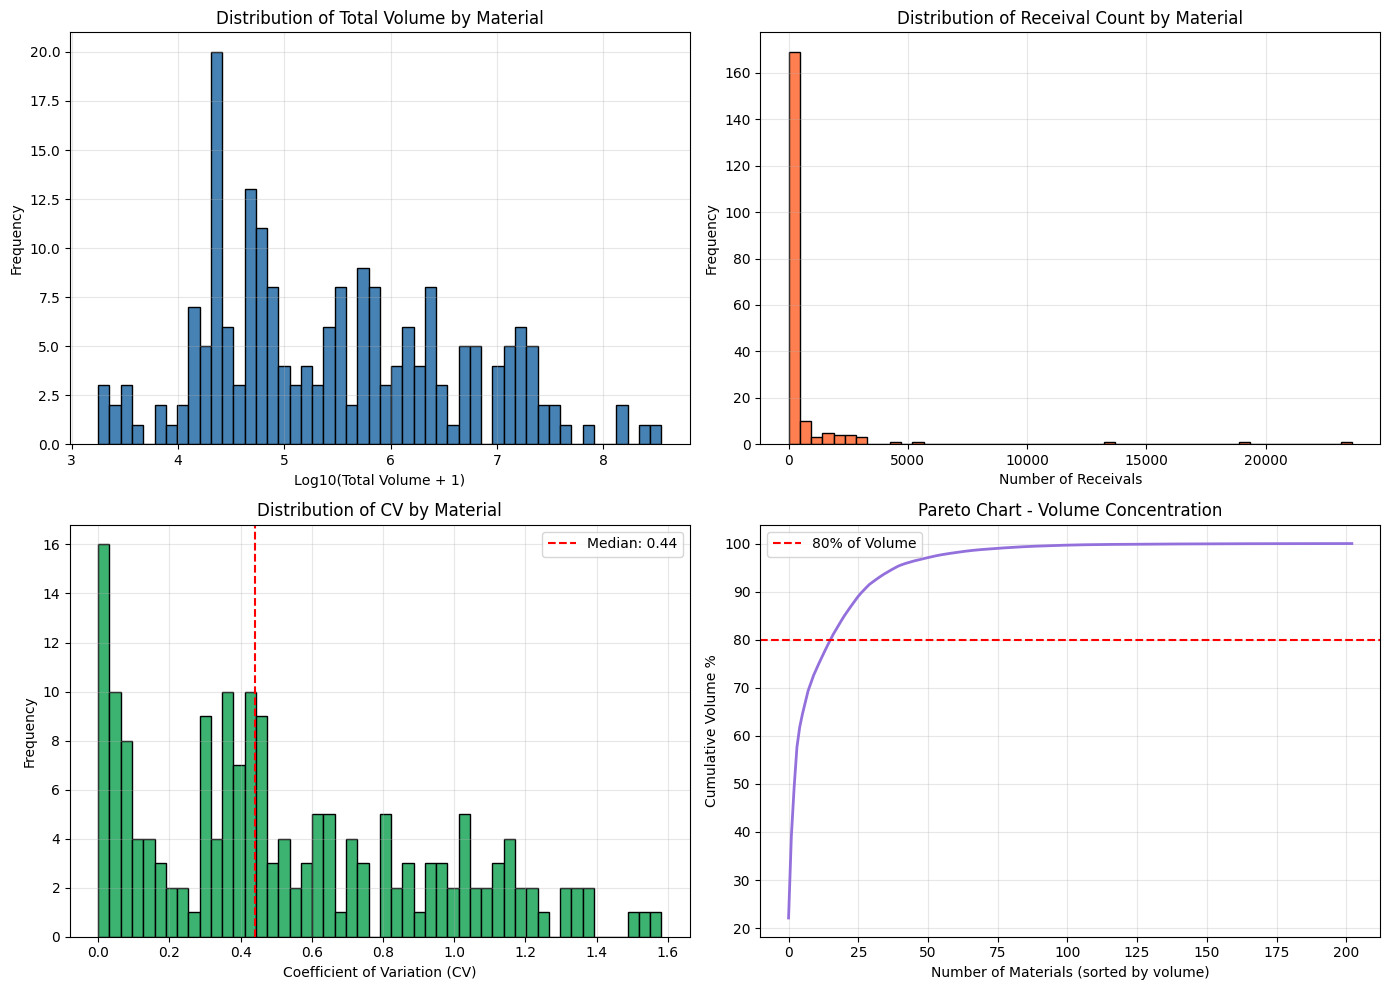


📌 Pareto Principle: 54 materials (26.6%) account for 80% of total volume


In [ ]:
# ============================================================================
# EDA 2: MATERIAL DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("EDA 2: MATERIAL DISTRIBUTION ANALYSIS")
print("=" * 80)

# Aggregate statistics by rm_id
df_by_rm = df_receivals.groupby('rm_id')['net_weight'].agg([
    ('total_weight', 'sum'),
    ('num_receivals', 'count'),
    ('avg_weight', 'mean'),
    ('std_weight', 'std'),
    ('min_weight', 'min'),
    ('max_weight', 'max')
]).reset_index()

# Calculate coefficient of variation (volatility measure)
df_by_rm['cv'] = df_by_rm['std_weight'] / df_by_rm['avg_weight']

print(f"\nTotal unique materials: {len(df_by_rm)}")
print(f"\nDescriptive statistics by material:")
print(df_by_rm[['total_weight', 'num_receivals', 'avg_weight', 'cv']].describe())

# Identify top materials by volume
print(f"\n--- TOP 10 MATERIALS BY TOTAL VOLUME ---")
df_top10 = df_by_rm.nlargest(10, 'total_weight')
print(df_top10[['rm_id', 'total_weight', 'num_receivals', 'avg_weight', 'cv']].to_string())

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Distribution of total volume (log scale)
axes[0, 0].hist(np.log10(df_by_rm['total_weight'] + 1), bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Log10(Total Volume + 1)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Total Volume by Material')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Distribution of receival count
axes[0, 1].hist(df_by_rm['num_receivals'], bins=50, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Number of Receivals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Receival Count by Material')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coefficient of Variation distribution
df_cv_valid = df_by_rm[df_by_rm['cv'].notna() & (df_by_rm['cv'] < 10)]  # Filter outliers
axes[1, 0].hist(df_cv_valid['cv'], bins=50, color='mediumseagreen', edgecolor='black')
axes[1, 0].axvline(df_cv_valid['cv'].median(), color='red', linestyle='--', label=f'Median: {df_cv_valid["cv"].median():.2f}')
axes[1, 0].set_xlabel('Coefficient of Variation (CV)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of CV by Material')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Pareto chart - volume concentration
df_pareto = df_by_rm.sort_values('total_weight', ascending=False).copy()
df_pareto['cumulative_pct'] = df_pareto['total_weight'].cumsum() / df_pareto['total_weight'].sum() * 100
axes[1, 1].plot(range(len(df_pareto)), df_pareto['cumulative_pct'], color='mediumpurple', linewidth=2)
axes[1, 1].axhline(80, color='red', linestyle='--', label='80% of Volume')
axes[1, 1].set_xlabel('Number of Materials (sorted by volume)')
axes[1, 1].set_ylabel('Cumulative Volume %')
axes[1, 1].set_title('Pareto Chart - Volume Concentration')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_rm_distribution.png', dpi=150, bbox_inches='tight')
print("\n✓ Chart saved: 'eda_rm_distribution.png'")
plt.show()

# Pareto principle analysis (80/20 rule)
idx_80pct = df_pareto[df_pareto['cumulative_pct'] >= 80].index[0]
num_rm_80pct = idx_80pct + 1
print(f"\n📌 Pareto Principle: {num_rm_80pct} materials ({num_rm_80pct/len(df_pareto)*100:.1f}%) account for 80% of total volume")

print("=" * 80)


EDA 3: PURCHASE ORDER ANALYSIS

Total purchase orders: 33,171
Total quantity ordered: 2,995,810,856.04 kg
Date range: 2002-01-30 00:00:00 → 2025-06-29 00:00:00

--- Purchase Orders for Forecast Period (2025 H1) ---
Number of POs: 147
Total quantity: 19,148,974.00 kg
Unique products: 17

Historical monthly average: 11,148,452.74 kg/month
2025 H1 monthly average: 3,829,794.80 kg/month
Change: -65.6%


/opt/anaconda3/envs/siv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



✓ Chart saved: 'eda_purchase_orders.png'


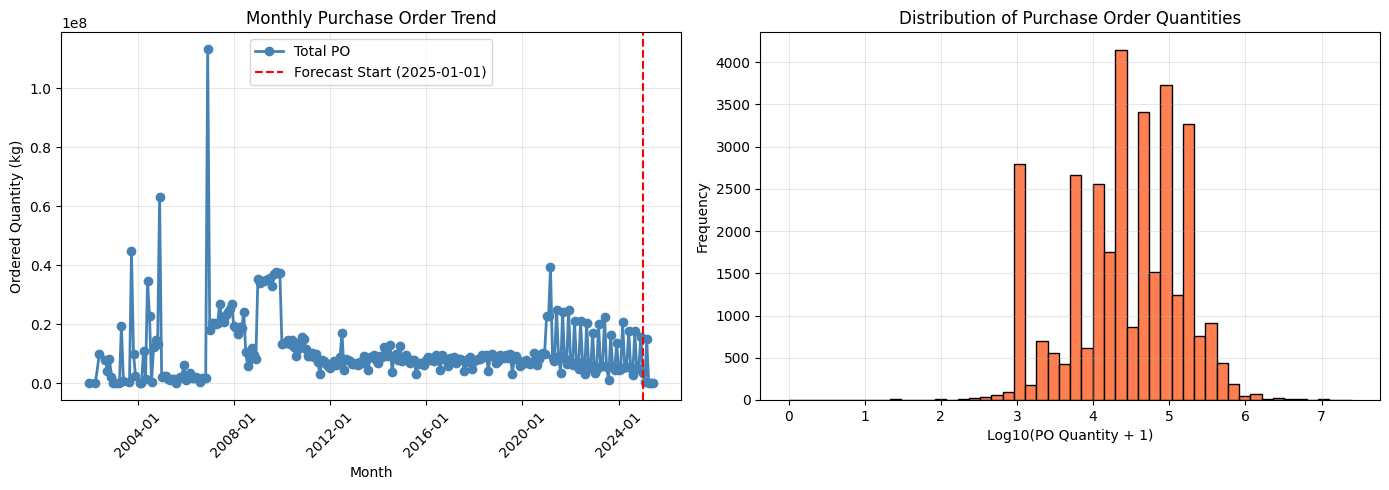

In [ ]:
# ============================================================================
# EDA 3: PURCHASE ORDER ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("EDA 3: PURCHASE ORDER ANALYSIS")
print("=" * 80)

# Prepare purchase order data for analysis
df_po_analysis = df_po.copy()
df_po_analysis['delivery_date'] = pd.to_datetime(df_po_analysis['delivery_date'], utc=True, errors='coerce').dt.tz_localize(None).dt.normalize()
df_po_analysis = df_po_analysis.dropna(subset=['delivery_date', 'product_id', 'quantity'])

print(f"\nTotal purchase orders: {len(df_po_analysis):,}")
print(f"Total quantity ordered: {df_po_analysis['quantity'].sum():,.2f} kg")
print(f"Date range: {df_po_analysis['delivery_date'].min()} → {df_po_analysis['delivery_date'].max()}")

# Filter PO for forecast period (2025 H1: Jan-May)
df_po_2025_eda = df_po_analysis[(df_po_analysis['delivery_date'] >= pred_start_date_dt) & 
                                 (df_po_analysis['delivery_date'] <= pred_end_date_dt)]

print(f"\n--- Purchase Orders for Forecast Period (2025 H1) ---")
print(f"Number of POs: {len(df_po_2025_eda):,}")
print(f"Total quantity: {df_po_2025_eda['quantity'].sum():,.2f} kg")
print(f"Unique products: {df_po_2025_eda['product_id'].nunique()}")

# Compare historical vs forecast period PO activity
df_po_hist = df_po_analysis[df_po_analysis['delivery_date'] < pred_start_date_dt]
avg_monthly_hist = df_po_hist.groupby(df_po_hist['delivery_date'].dt.to_period('M'))['quantity'].sum().mean()
total_2025_5months = df_po_2025_eda['quantity'].sum()
avg_monthly_2025 = total_2025_5months / 5

print(f"\nHistorical monthly average: {avg_monthly_hist:,.2f} kg/month")
print(f"2025 H1 monthly average: {avg_monthly_2025:,.2f} kg/month")
print(f"Change: {(avg_monthly_2025 / avg_monthly_hist - 1) * 100:+.1f}%")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Monthly PO trend
df_po_monthly = df_po_analysis.copy()
df_po_monthly['year_month'] = df_po_monthly['delivery_date'].dt.to_period('M')
df_po_monthly_agg = df_po_monthly.groupby('year_month')['quantity'].sum().reset_index()
df_po_monthly_agg['year_month'] = df_po_monthly_agg['year_month'].dt.to_timestamp()

axes[0].plot(df_po_monthly_agg['year_month'], df_po_monthly_agg['quantity'], 
             marker='o', color='steelblue', linewidth=2, label='Total PO')
axes[0].axvline(pred_start_date_dt, color='red', linestyle='--', label='Forecast Start (2025-01-01)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Ordered Quantity (kg)')
axes[0].set_title('Monthly Purchase Order Trend')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Plot 2: PO quantity distribution
axes[1].hist(np.log10(df_po_analysis['quantity'] + 1), bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('Log10(PO Quantity + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Purchase Order Quantities')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_purchase_orders.png', dpi=150, bbox_inches='tight')
print("\n✓ Chart saved: 'eda_purchase_orders.png'")
plt.show()

print("=" * 80)

In [ ]:
# Preview the master dataframe structure
df_master_mpe

,rm_id,date,net_weight,po_expected_quantity,dayofweek,month,dayofyear,year,weekofyear,is_weekend,...,lag_14,lag_28,lag_30,lag_91,lag_182,lag_270,lag_364,lag_7_roll_mean_14,lag_364_roll_mean_7,lag_30_roll_mean_90
0,343,2004-06-15,0.0,0.0,1,6,167,2004,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,343,2004-06-16,0.0,0.0,2,6,168,2004,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,343,2004-06-17,0.0,0.0,3,6,169,2004,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,343,2004-06-18,0.0,0.0,4,6,170,2004,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,343,2004-06-19,0.0,0.0,5,6,171,2004,25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926371,4501,2025-05-27,NaN,0.0,1,5,147,2025,22,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
926372,4501,2025-05-28,NaN,0.0,2,5,148,2025,22,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
926373,4501,2025-05-29,NaN,0.0,3,5,149,2025,22,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
926374,4501,2025-05-30,NaN,0.0,4,5,150,2025,22,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
# ============================================================================
# SECTION 7: MODEL TRAINING (MATERIAL-SPECIFIC MODELS)
# ============================================================================

print("\n[6/9] Training material-specific LightGBM models...")

# Initialize storage for trained models
mpe_models = {}

# Define target variable and feature set
reg_target = 'net_weight'
mpe_features = [col for col in df_master_mpe.columns if col not in ['net_weight', 'date', 'rm_id'] and 'po_' not in col]
categorical_features_mpe = ['dayofweek', 'month', 'weekofyear', 'is_weekend']
categorical_features_mpe = [col for col in categorical_features_mpe if col in mpe_features]

print(f"Number of features: {len(mpe_features)}")

# LightGBM hyperparameters (optimized for MAE, robust to outliers)
lgbm_reg_params = {
    'objective': 'mae',           # Mean Absolute Error objective
    'metric': 'mae',              # Evaluation metric
    'n_estimators': 1000,         # Maximum trees (early stopping will optimize)
    'learning_rate': 0.05,        # Conservative learning rate
    'n_jobs': -1,                 # Use all CPU cores
    'seed': 42,                   # Reproducibility
    'verbose': -1,                # Suppress training logs
    'colsample_bytree': 0.8,      # Feature sampling per tree
    'subsample': 0.8,             # Row sampling per tree
    'min_data_in_leaf': 20        # Minimum samples per leaf (regularization)
}

base_regressor = lgb.LGBMRegressor(**lgbm_reg_params)
validation_predictions = []

# Define validation period (last ~150 days of 2024, matching test period length)
valid_start_date = datetime.strptime('2024-08-01', '%Y-%m-%d')

# Train one model per active material
for rm_id_current in active_rm_ids:
    
    # Extract data for current material
    df_current = df_master_mpe[df_master_mpe['rm_id'] == rm_id_current].copy()
    
    # Split into train/validation sets
    train_df_current = df_current[df_current['date'] < pred_start_date_dt]
    valid_df_current = df_current[(df_current['date'] >= valid_start_date) & (df_current['date'] < pred_start_date_dt)]
    train_only_df_current = train_df_current[train_df_current['date'] < valid_start_date]
    
    # Skip materials with insufficient training data
    if len(train_only_df_current) < 100 or len(valid_df_current) == 0:
        continue
    
    # Prepare feature matrices
    X_train_curr = train_only_df_current[mpe_features]
    y_train_curr = train_only_df_current[reg_target]
    X_valid_curr = valid_df_current[mpe_features]
    y_valid_curr = valid_df_current[reg_target]
    
    # Apply categorical dtype (required by LightGBM)
    for col in categorical_features_mpe:
        X_train_curr.loc[:, col] = X_train_curr[col].astype('category')
        X_valid_curr.loc[:, col] = X_valid_curr[col].astype('category')
    
    # Train with early stopping
    model_current = clone(base_regressor)
    model_current.fit(
        X_train_curr, y_train_curr,
        eval_set=[(X_valid_curr, y_valid_curr)],
        eval_metric='mae',
        callbacks=[lgb.early_stopping(50)],
        categorical_feature=categorical_features_mpe
    )
    
    # Get optimal number of trees
    best_iter_mpe = model_current.best_iteration_ if (model_current.best_iteration_ and model_current.best_iteration_ > 0) else lgbm_reg_params['n_estimators']
    
    # Retrain on full training data (including validation period) with optimal iterations
    model_final_mpe = clone(base_regressor)
    model_final_mpe.set_params(n_estimators=best_iter_mpe)
    
    X_train_final_curr = train_df_current[mpe_features].copy()
    y_train_final_curr = train_df_current[reg_target].copy()
    
    for col in categorical_features_mpe:
        X_train_final_curr.loc[:, col] = X_train_final_curr[col].astype('category')
    
    model_final_mpe.fit(X_train_final_curr, y_train_final_curr, categorical_feature=categorical_features_mpe)
    
    # Store trained model
    mpe_models[rm_id_current] = model_final_mpe
    
    # Generate validation predictions for evaluation
    daily_preds_v = model_current.predict(X_valid_curr)
    daily_preds_v = np.maximum(0, daily_preds_v)  # Ensure non-negative predictions
    valid_df_current['y_pred_daily'] = daily_preds_v
    validation_predictions.append(valid_df_current[['rm_id', 'date', 'net_weight', 'y_pred_daily']])
    
    # Clean up memory
    del df_current, train_df_current, valid_df_current, train_only_df_current
    del X_train_curr, y_train_curr, X_valid_curr, y_valid_curr, X_train_final_curr, y_train_final_curr
    gc.collect()

print(f"✓ Trained {len(mpe_models)} material-specific models")

# Evaluate validation performance using Quantile Error
if validation_predictions:
    df_valid_results_mpe = pd.concat(validation_predictions, ignore_index=True)
    
    # Calculate cumulative predictions per material
    df_valid_cum_score_mpe = df_valid_results_mpe.groupby('rm_id').agg(
        A_i=('net_weight', 'sum'),        # Actual cumulative
        F_i=('y_pred_daily', 'sum')       # Forecasted cumulative
    ).reset_index()
    
    # Compute Quantile Error
    validation_score_mpe = quantile_error(df_valid_cum_score_mpe['A_i'], df_valid_cum_score_mpe['F_i'], q=0.2)
    print(f"\n*** Validation Quantile Error (Aug-Dec 2024, ~150 days): {validation_score_mpe:.4f} ***")
else:
    print("\nNo validation predictions generated.")

print("=" * 80)


[6/9] Training material-specific LightGBM models...
Number of features: 17
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1

In [ ]:
# Define which lag features need to be updated during recursive forecasting
# Key: lag period name, Value: number of days to shift
LAGS_TO_UPDATE = {7: 7, 14: 14, 28: 28, 30: 30, 91: 91, 182: 182, 270: 270, 364: 364}

In [ ]:
# ============================================================================
# SECTION 8: RECURSIVE FORECASTING
# ============================================================================

print("\n[7/9] Generating recursive forecasts for 2025 H1...")

all_predictions = []

# Define lag features that need recursive updating
LAGS_TO_UPDATE = {7: 7, 14: 14, 28: 28, 30: 30, 91: 91, 182: 182, 270: 270, 364: 364}

# Generate predictions for each material
for rm_id_current, model_current in mpe_models.items():
    
    # Extract future dates for this material
    df_future = df_master_mpe[(df_master_mpe['rm_id'] == rm_id_current) & (df_master_mpe['date'] >= pred_start_date_dt)].copy()
    
    if df_future.empty:
        continue
    
    # 1. Create recursive dataframe: Last historical row + Future rows
    #    This allows lag features to reference the last known actual values
    last_row_df = df_master_mpe[df_master_mpe['date'] == end_of_2024]
    last_row_df = last_row_df[last_row_df['rm_id'] == rm_id_current].copy()
    
    df_recursive = pd.concat([last_row_df, df_future], ignore_index=True)
    
    # 2. Recursive prediction loop (day by day)
    for i in range(1, len(df_recursive)):  # Start from first forecast day
        
        # Extract features for current day
        X_current_day = df_recursive.loc[[i], mpe_features].copy()
        
        # Apply categorical dtype
        for col in categorical_features_mpe:
            X_current_day.loc[:, col] = X_current_day[col].astype('category')
        
        # Generate prediction for this day
        daily_pred = model_current.predict(X_current_day)[0]
        daily_pred = np.maximum(0, daily_pred)  # Ensure non-negative
        
        # 3. Store prediction as "actual" for this day
        df_recursive.loc[i, 'net_weight'] = daily_pred
        
        # 4. Update lag features for future days using current prediction
        if i + 1 < len(df_recursive):
            for lag_period, lag_shift in LAGS_TO_UPDATE.items():
                if i + lag_shift < len(df_recursive):
                    # Update lag_X feature X days ahead with current prediction
                    df_recursive.loc[i + lag_shift, f'lag_{lag_period}'] = daily_pred
    
    # 5. Extract final predictions (skip the historical row at index 0)
    df_future['predicted_daily_weight'] = df_recursive.loc[1:, 'net_weight'].values
    all_predictions.append(df_future[['rm_id', 'date', 'predicted_daily_weight']])

# Combine all predictions
if all_predictions:
    df_predictions_mpe = pd.concat(all_predictions, ignore_index=True)
else:
    df_predictions_mpe = pd.DataFrame(columns=['rm_id', 'date', 'predicted_daily_weight'])

print(f"✓ Generated {len(df_predictions_mpe):,} daily predictions")
print("=" * 80)


[7/9] Generating recursive forecasts for 2025 H1...
✓ Generated 18,271 daily predictions


In [ ]:
# ============================================================================
# SECTION 9: CUMULATIVE AGGREGATION
# ============================================================================

print("\n[8/9] Computing cumulative predictions...")

# Sort predictions chronologically
df_predictions_mpe.sort_values(by=['rm_id', 'date'], inplace=True)

# Calculate cumulative sum per material
if not df_predictions_mpe.empty:
    df_predictions_mpe['cumulative_prediction'] = df_predictions_mpe.groupby('rm_id')['predicted_daily_weight'].cumsum()
else:
    df_predictions_mpe['cumulative_prediction'] = pd.Series(dtype='float64')

# Merge with prediction mapping to match required forecast dates
df_mapping['forecast_end_date'] = pd.to_datetime(df_mapping['forecast_end_date'])

print("Mapping predictions to submission format...")
df_submission = pd.merge(
    df_mapping,
    df_predictions_mpe[['rm_id', 'date', 'cumulative_prediction']],
    left_on=['rm_id', 'forecast_end_date'],
    right_on=['rm_id', 'date'],
    how='left'
)

# Format for submission
df_submission = df_submission[['ID', 'cumulative_prediction', 'rm_id']]
df_submission.rename(columns={'cumulative_prediction': 'predicted_weight'}, inplace=True)

# Set inactive materials to 0
print("Setting predictions to 0 for inactive materials...")
df_submission['predicted_weight'] = df_submission['predicted_weight'].fillna(0)

print(f"✓ Prepared {len(df_submission)} submission predictions")
print("=" * 80)


[8/9] Computing cumulative predictions...
Mapping predictions to submission format...
Setting predictions to 0 for inactive materials...
✓ Prepared 30450 submission predictions


In [ ]:
# ============================================================================
# SECTION 10: ADAPTIVE SHRINKAGE FACTOR CALCULATION
# ============================================================================

print("\n[9/9] Computing adaptive shrinkage factors per material...")

# Dictionary to store material-specific shrinkage factors
shrinkage_factors = {}

# Prepare PO data for analysis
df_po_clean = df_po_merged[['rm_id', 'date', 'quantity']].copy()
df_po_clean.rename(columns={'date': 'delivery_date'}, inplace=True)
df_po_clean = df_po_clean.dropna(subset=['delivery_date', 'rm_id', 'quantity'])

# Filter PO for forecast period
df_po_2025H1 = df_po_clean[(df_po_clean['delivery_date'] >= pred_start_date_dt) & 
                            (df_po_clean['delivery_date'] <= pred_end_date_dt)]

# Calculate shrinkage factor for each active material
for rm_id_current in mpe_models.keys():
    
    # CRITERION 1: Coefficient of Variation (volatility measure)
    df_rm_hist = df_daily_target[df_daily_target['rm_id'] == rm_id_current]
    
    if len(df_rm_hist) > 0:
        mean_daily = df_rm_hist['net_weight'].mean()
        std_daily = df_rm_hist['net_weight'].std()
        cv = std_daily / mean_daily if mean_daily > 0 else 0
    else:
        cv = 0
    
    # CRITERION 2: Recency (days since last receival)
    if len(df_rm_hist) > 0:
        last_receival_date = df_rm_hist['date'].max()
        days_since_last = (end_of_2024 - last_receival_date).days
    else:
        days_since_last = 999  # High value for materials with no history
    
    # CRITERION 3: PO Reliability (ratio of received vs ordered)
    df_po_rm_hist = df_po_clean[(df_po_clean['rm_id'] == rm_id_current) & 
                                  (df_po_clean['delivery_date'] < pred_start_date_dt)]
    
    total_po_qty_hist = df_po_rm_hist['quantity'].sum() if len(df_po_rm_hist) > 0 else 0
    total_receival_hist = df_rm_hist['net_weight'].sum() if len(df_rm_hist) > 0 else 0
    
    po_reliability = total_receival_hist / total_po_qty_hist if total_po_qty_hist > 0 else 0
    
    # CRITERION 4: Future PO quantity for 2025 H1
    df_po_rm_2025 = df_po_2025H1[df_po_2025H1['rm_id'] == rm_id_current]
    total_po_qty_2025H1 = df_po_rm_2025['quantity'].sum() if len(df_po_rm_2025) > 0 else 0
    
    # --- ADAPTIVE SHRINKAGE LOGIC ---
    base_shrinkage = 0.94  # Conservative baseline
    
    # Adjustment 1: High CV → more conservative
    cv_adjustment = 0
    if cv > 2.0:
        cv_adjustment = -0.03  # Very volatile
    elif cv > 1.5:
        cv_adjustment = -0.02  # Moderately volatile
    
    # Adjustment 2: Long time since last receival → more conservative
    recency_adjustment = 0
    if days_since_last > 180:
        recency_adjustment = -0.03  # Inactive for 6+ months
    elif days_since_last > 90:
        recency_adjustment = -0.02  # Inactive for 3-6 months
    
    # Adjustment 3: Low PO reliability → more conservative
    po_adjustment = 0
    if 0 < po_reliability < 0.7:
        po_adjustment = -0.02  # Historically receives only 70% of orders
    elif 0 < po_reliability < 0.85:
        po_adjustment = -0.01  # Historically receives 70-85% of orders
    
    # Adjustment 4: No/low future PO → more conservative
    po_2025_adjustment = 0
    if total_po_qty_2025H1 == 0:
        po_2025_adjustment = -0.04  # No orders for forecast period
    elif total_po_qty_2025H1 < (total_receival_hist / 365 * 151):  # Less than historical trend
        po_2025_adjustment = -0.02
    
    # Calculate final shrinkage factor
    shrinkage_rm = base_shrinkage + cv_adjustment + recency_adjustment + po_adjustment + po_2025_adjustment
    
    # Clamp to reasonable range [0.85, 0.97]
    shrinkage_rm = np.clip(shrinkage_rm, 0.85, 0.97)
    
    shrinkage_factors[rm_id_current] = shrinkage_rm

print(f"✓ Calculated shrinkage factors for {len(shrinkage_factors)} materials")

# Display shrinkage statistics
shrinkage_df = pd.DataFrame(list(shrinkage_factors.items()), columns=['rm_id', 'shrinkage_factor'])
shrinkage_df = shrinkage_df.sort_values(by='shrinkage_factor')

print("\n--- Most Conservative Materials (lowest shrinkage) ---")
print(shrinkage_df.head(10).to_string(index=False))

print("\n--- Least Conservative Materials (highest shrinkage) ---")
print(shrinkage_df.tail(10).to_string(index=False))

print(f"\nShrinkage Statistics:")
print(f"  Mean:   {shrinkage_df['shrinkage_factor'].mean():.4f}")
print(f"  Median: {shrinkage_df['shrinkage_factor'].median():.4f}")
print(f"  Min:    {shrinkage_df['shrinkage_factor'].min():.4f}")
print(f"  Max:    {shrinkage_df['shrinkage_factor'].max():.4f}")

print("=" * 80)


[9/9] Computing adaptive shrinkage factors per material...
✓ Calculated shrinkage factors for 121 materials

--- Most Conservative Materials (lowest shrinkage) ---
 rm_id  shrinkage_factor
  2153              0.85
  2981              0.85
  3761              0.85
  3762              0.85
  3802              0.85
  3921              0.85
  4101              0.85
  3821              0.85
  4401              0.86
  2140              0.86

--- Least Conservative Materials (highest shrinkage) ---
 rm_id  shrinkage_factor
  2741              0.91
  2125              0.92
  3421              0.92
  4222              0.92
  3865              0.92
  3781              0.92
  3701              0.92
  3381              0.92
  4263              0.92
  4481              0.92

Shrinkage Statistics:
  Mean:   0.8870
  Median: 0.8900
  Min:    0.8500
  Max:    0.9200


In [ ]:
# ============================================================================
# SECTION 11: APPLY ADAPTIVE SHRINKAGE AND GENERATE SUBMISSION
# ============================================================================

print("\nApplying adaptive shrinkage to predictions...")

# Function to apply material-specific shrinkage
def apply_shrinkage(row):
    """Apply shrinkage factor specific to each material."""
    rm_id = row['rm_id']
    if rm_id in shrinkage_factors:
        return row['predicted_weight'] * shrinkage_factors[rm_id]
    else:
        # Inactive materials remain at 0
        return row['predicted_weight']

# Store pre-shrinkage predictions for comparison
df_submission['predicted_weight_pre_shrinkage'] = df_submission['predicted_weight'].copy()

# Apply shrinkage (BEFORE removing rm_id column)
df_submission['predicted_weight'] = df_submission.apply(apply_shrinkage, axis=1)

# Calculate effective shrinkage
total_pre_shrinkage = df_submission['predicted_weight_pre_shrinkage'].sum()
total_post_shrinkage = df_submission['predicted_weight'].sum()
effective_shrinkage = total_post_shrinkage / total_pre_shrinkage if total_pre_shrinkage > 0 else 0

print(f"\nShrinkage Impact:")
print(f"  Total predictions BEFORE shrinkage: {total_pre_shrinkage:,.2f} kg")
print(f"  Total predictions AFTER shrinkage:  {total_post_shrinkage:,.2f} kg")
print(f"  Effective average shrinkage:        {effective_shrinkage:.4f}")

# Prepare final submission file (NOW remove rm_id and other temporary columns)
df_submission = df_submission[['ID', 'predicted_weight']]

output_filename = '../submissions/submission_best.csv'
df_submission.to_csv(output_filename, index=False)

print("\n" + "=" * 80)
print(f"✓ Submission file generated: '{output_filename}'")
print(f"✓ Total predictions: {len(df_submission):,}")
print("=" * 80)
print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY")
print("=" * 80)


Applying adaptive shrinkage to predictions...

Shrinkage Impact:
  Total predictions BEFORE shrinkage: 1,547,125,255.62 kg
  Total predictions AFTER shrinkage:  1,400,851,961.71 kg
  Effective average shrinkage:        0.9055

✓ Submission file generated: '../submissions/submission_best.csv'
✓ Total predictions: 30,450

🎉 PIPELINE COMPLETED SUCCESSFULLY


# Adaptive Shrinkage Strategy

## Overview
To minimize the risk of overestimation (which is heavily penalized by the Quantile Error metric with q=0.2), we apply a **material-specific shrinkage factor** to all predictions. This conservative adjustment is data-driven and adapts to each material's unique characteristics.

## Methodology

### Base Shrinkage
- **Starting point**: 0.94 (6% reduction)
- This provides a conservative baseline for all materials

### Four Adjustment Criteria

#### 1. **Coefficient of Variation (CV)**
*Measures volatility of historical receivals*

- **High CV** indicates unpredictable behavior → need more caution
- **Adjustments**:
  - CV > 2.0: **-3%** (very volatile)
  - CV > 1.5: **-2%** (moderately volatile)

#### 2. **Recency**
*Days since last receival*

- **Long inactivity** increases uncertainty about future receivals
- **Adjustments**:
  - > 180 days: **-3%** (inactive for 6+ months)
  - > 90 days: **-2%** (inactive for 3-6 months)

#### 3. **PO Reliability**
*Historical ratio: actual receivals / ordered quantity*

- **Low reliability** suggests systematic under-delivery
- **Adjustments**:
  - Ratio < 0.7: **-2%** (receives only 70% of orders)
  - Ratio < 0.85: **-1%** (receives 70-85% of orders)

#### 4. **Future Purchase Orders**
*Quantity ordered for 2025 H1*

- **Absence of orders** is a strong signal of reduced/ceased activity
- **Adjustments**:
  - No PO for 2025: **-4%** (strong risk indicator)
  - PO below historical trend: **-2%** (reduced activity)

## Formula

```
shrinkage_factor = base_shrinkage + cv_adj + recency_adj + po_reliability_adj + po_2025_adj
```

**Final range**: Clamped to [0.85, 0.97] to avoid extreme adjustments

## Benefits

1. **Individualized**: Each material gets custom treatment based on its behavior
2. **Conservative bias**: Aligns with Quantile Error optimization (q=0.2)
3. **Transparent**: Every adjustment is traceable and interpretable
4. **Data-driven**: Uses only historical data and declared future orders


DIAGNOSTIC ANALYSIS: SHRINKAGE FACTORS BY MATERIAL

=== TOP 15 MOST CONSERVATIVE MATERIALS (lowest shrinkage) ===
 rm_id  shrinkage_factor       cv  days_since_last  po_reliability  po_qty_2025H1  total_receival_2024
  2153              0.85 0.635247              718        0.204968            0.0           19319192.0
  2981              0.85 0.426552              330        0.516966            0.0            3125142.0
  3761              0.85 0.433956              307        0.007641            0.0            1818763.0
  3762              0.85 0.478167              571        0.000972            0.0             231400.0
  3802              0.85      NaN              649        0.486400            0.0              24320.0
  3921              0.85      NaN              438        0.004132            0.0              24980.0
  4101              0.85      NaN              378        0.405600            0.0              20280.0
  3821              0.85 0.270128              579        0.0

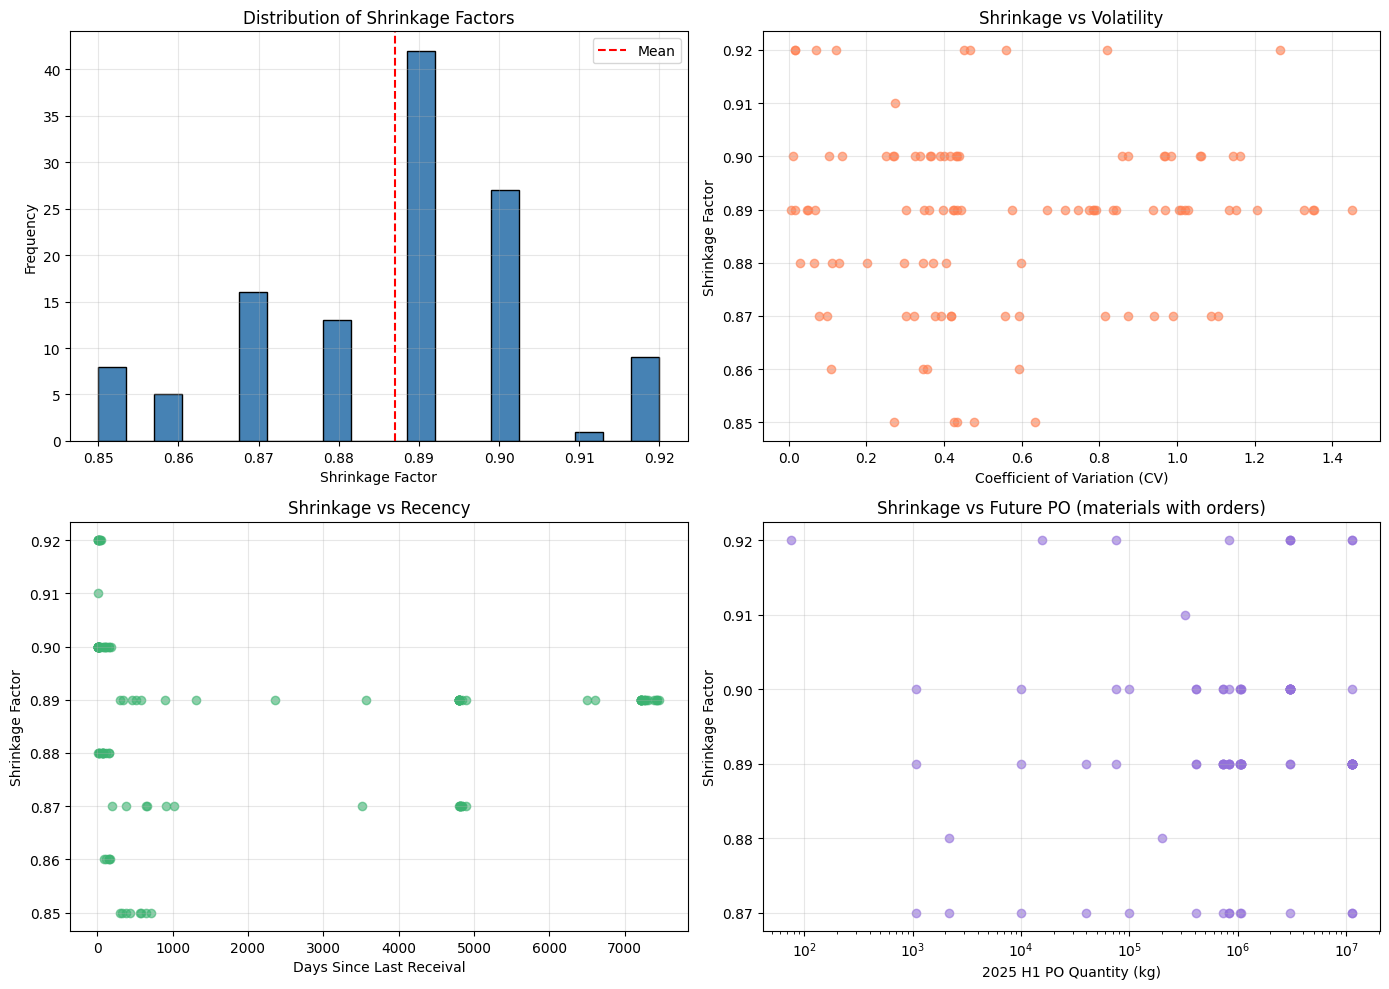

In [ ]:
# ============================================================================
# DIAGNOSTIC ANALYSIS: SHRINKAGE FACTORS
# ============================================================================

print("\n" + "=" * 80)
print("DIAGNOSTIC ANALYSIS: SHRINKAGE FACTORS BY MATERIAL")
print("=" * 80)

# Prepare detailed analysis dataframe
shrinkage_analysis = []

for rm_id_current in shrinkage_factors.keys():
    
    # Historical receival data
    df_rm_hist = df_daily_target[df_daily_target['rm_id'] == rm_id_current]
    
    if len(df_rm_hist) > 0:
        mean_daily = df_rm_hist['net_weight'].mean()
        std_daily = df_rm_hist['net_weight'].std()
        cv = std_daily / mean_daily if mean_daily > 0 else 0
        last_receival_date = df_rm_hist['date'].max()
        days_since_last = (end_of_2024 - last_receival_date).days
        total_receival_hist = df_rm_hist['net_weight'].sum()
    else:
        cv = 0
        days_since_last = 999
        total_receival_hist = 0
    
    # PO reliability
    df_po_rm_hist = df_po_clean[(df_po_clean['rm_id'] == rm_id_current) & 
                                  (df_po_clean['delivery_date'] < pred_start_date_dt)]
    total_po_qty_hist = df_po_rm_hist['quantity'].sum() if len(df_po_rm_hist) > 0 else 0
    po_reliability = total_receival_hist / total_po_qty_hist if total_po_qty_hist > 0 else 0
    
    # Future PO
    df_po_rm_2025 = df_po_2025H1[df_po_2025H1['rm_id'] == rm_id_current]
    total_po_qty_2025H1 = df_po_rm_2025['quantity'].sum() if len(df_po_rm_2025) > 0 else 0
    
    shrinkage_analysis.append({
        'rm_id': rm_id_current,
        'shrinkage_factor': shrinkage_factors[rm_id_current],
        'cv': cv,
        'days_since_last': days_since_last,
        'po_reliability': po_reliability,
        'po_qty_2025H1': total_po_qty_2025H1,
        'total_receival_2024': total_receival_hist
    })

df_shrinkage_analysis = pd.DataFrame(shrinkage_analysis)
df_shrinkage_analysis = df_shrinkage_analysis.sort_values(by='shrinkage_factor')

print("\n=== TOP 15 MOST CONSERVATIVE MATERIALS (lowest shrinkage) ===")
print(df_shrinkage_analysis.head(15).to_string(index=False))

print("\n=== TOP 15 LEAST CONSERVATIVE MATERIALS (highest shrinkage) ===")
print(df_shrinkage_analysis.tail(15).to_string(index=False))

# Statistical summary
print("\n=== SHRINKAGE FACTOR DISTRIBUTION ===")
print(df_shrinkage_analysis['shrinkage_factor'].describe())

# Categorize by shrinkage level
print("\n=== MATERIALS BY SHRINKAGE CATEGORY ===")
df_shrinkage_analysis['shrinkage_category'] = pd.cut(
    df_shrinkage_analysis['shrinkage_factor'], 
    bins=[0.84, 0.88, 0.92, 0.95, 1.0],
    labels=['Very Conservative (0.85-0.88)', 'Conservative (0.88-0.92)', 
            'Moderate (0.92-0.95)', 'Light (0.95-0.97)']
)
print(df_shrinkage_analysis['shrinkage_category'].value_counts().sort_index())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Shrinkage factor distribution
axes[0, 0].hist(df_shrinkage_analysis['shrinkage_factor'], bins=20, color='steelblue', edgecolor='black')
axes[0, 0].axvline(df_shrinkage_analysis['shrinkage_factor'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].set_xlabel('Shrinkage Factor')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Shrinkage Factors')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Shrinkage vs CV
axes[0, 1].scatter(df_shrinkage_analysis['cv'], df_shrinkage_analysis['shrinkage_factor'], 
                   alpha=0.6, color='coral')
axes[0, 1].set_xlabel('Coefficient of Variation (CV)')
axes[0, 1].set_ylabel('Shrinkage Factor')
axes[0, 1].set_title('Shrinkage vs Volatility')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Shrinkage vs Recency
axes[1, 0].scatter(df_shrinkage_analysis['days_since_last'], df_shrinkage_analysis['shrinkage_factor'], 
                   alpha=0.6, color='mediumseagreen')
axes[1, 0].set_xlabel('Days Since Last Receival')
axes[1, 0].set_ylabel('Shrinkage Factor')
axes[1, 0].set_title('Shrinkage vs Recency')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Shrinkage vs Future PO (materials with PO only)
df_with_po = df_shrinkage_analysis[df_shrinkage_analysis['po_qty_2025H1'] > 0]
axes[1, 1].scatter(df_with_po['po_qty_2025H1'], df_with_po['shrinkage_factor'], 
                   alpha=0.6, color='mediumpurple')
axes[1, 1].set_xlabel('2025 H1 PO Quantity (kg)')
axes[1, 1].set_ylabel('Shrinkage Factor')
axes[1, 1].set_title('Shrinkage vs Future PO (materials with orders)')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('shrinkage_analysis_diagnostics.png', dpi=150, bbox_inches='tight')
print("\n✓ Charts saved: 'shrinkage_analysis_diagnostics.png'")
plt.show()

print("=" * 80)

In [ ]:
# Preview daily predictions dataframe
df_predictions_mpe

,rm_id,date,predicted_daily_weight,cumulative_prediction
0,343,2025-01-01,0.0,0.0
1,343,2025-01-02,0.0,0.0
2,343,2025-01-03,0.0,0.0
3,343,2025-01-04,0.0,0.0
4,343,2025-01-05,0.0,0.0
...,...,...,...,...
18266,4501,2025-05-27,0.0,0.0
18267,4501,2025-05-28,0.0,0.0
18268,4501,2025-05-29,0.0,0.0
18269,4501,2025-05-30,0.0,0.0



Generating validation plot for material: 3282...


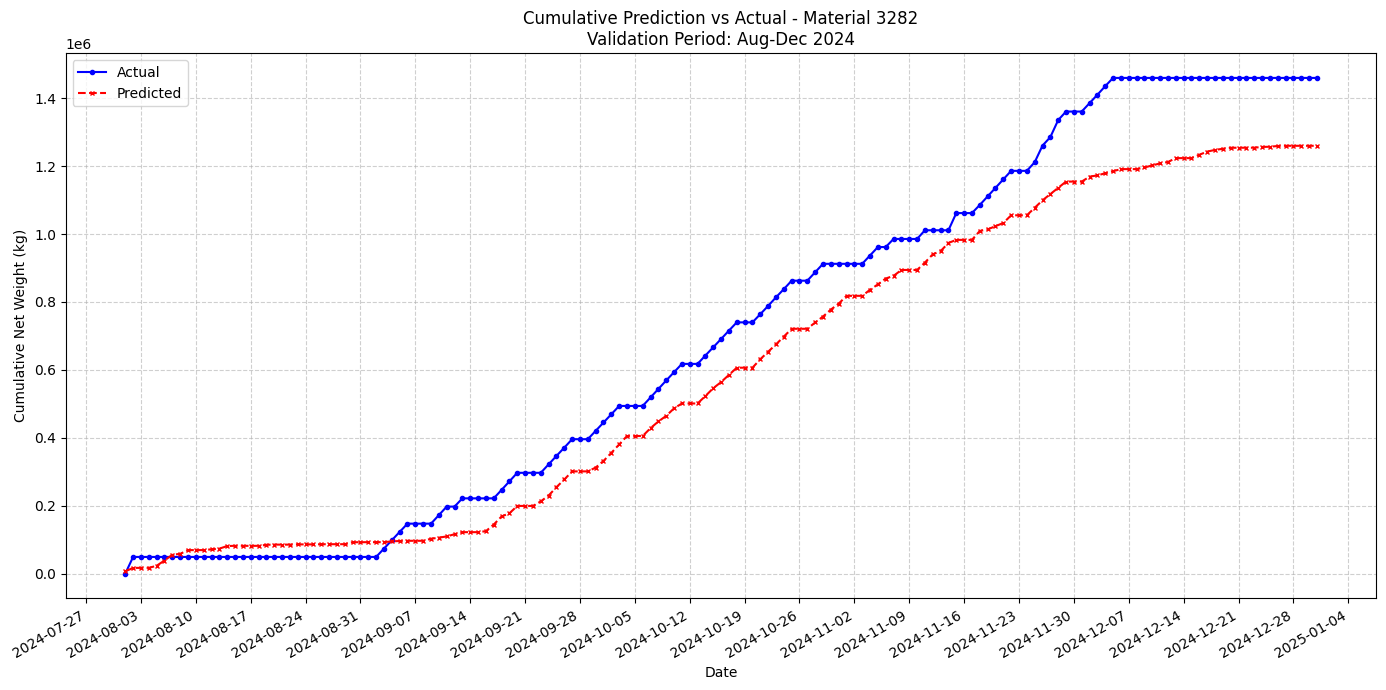

In [ ]:
# ============================================================================
# VALIDATION VISUALIZATION: CUMULATIVE PREDICTIONS
# ============================================================================

# Select a material for detailed validation plot
RM_ID_TO_PLOT = 3282

print(f"\nGenerating validation plot for material: {RM_ID_TO_PLOT}...")

if not df_valid_results_mpe.empty and RM_ID_TO_PLOT in df_valid_results_mpe['rm_id'].unique():
    df_plot = df_valid_results_mpe[df_valid_results_mpe['rm_id'] == RM_ID_TO_PLOT].copy()
    df_plot.sort_values(by='date', inplace=True)
    
    # Rename for clarity
    df_plot.rename(columns={'net_weight': 'y_true'}, inplace=True)
    
    # Calculate cumulative values
    df_plot['actual_cumulative'] = df_plot['y_true'].cumsum()
    df_plot['predicted_cumulative'] = df_plot['y_pred_daily'].cumsum()
    
    # Create plot
    plt.figure(figsize=(14, 7))
    plt.plot(df_plot['date'], df_plot['actual_cumulative'], 
             label='Actual', color='blue', marker='o', markersize=3, linestyle='-')
    plt.plot(df_plot['date'], df_plot['predicted_cumulative'], 
             label='Predicted', color='red', marker='x', markersize=3, linestyle='--')
    plt.title(f'Cumulative Prediction vs Actual - Material {RM_ID_TO_PLOT}\nValidation Period: Aug-Dec 2024')
    plt.ylabel('Cumulative Net Weight (kg)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()
else:
    print(f"No validation data available for material {RM_ID_TO_PLOT}")

In [ ]:
# ============================================================================
# ERROR ANALYSIS: WORST PERFORMING MATERIALS
# ============================================================================

print("\n" + "=" * 80)
print("ERROR ANALYSIS: MATERIALS WITH HIGHEST QUANTILE ERROR")
print("=" * 80)

if validation_predictions:
    df_valid_results_mpe = pd.concat(validation_predictions, ignore_index=True)
    
    # Calculate cumulative totals per material
    df_valid_cum_score_mpe = df_valid_results_mpe.groupby('rm_id').agg(
        A_i=('net_weight', 'sum'),        # Actual total
        F_i=('y_pred_daily', 'sum')       # Forecast total
    ).reset_index()
    
    # Calculate individual Quantile Error per material
    A_i = df_valid_cum_score_mpe['A_i']
    F_i = df_valid_cum_score_mpe['F_i']
    q = 0.2
    quantile_loss_per_id = np.maximum(q * (A_i - F_i), (1 - q) * (F_i - A_i))
    
    # Create error analysis dataframe
    df_error_analysis = pd.DataFrame({
        'rm_id': df_valid_cum_score_mpe['rm_id'],
        'Actual_Total_Weight': A_i,
        'Predicted_Total_Weight': F_i,
        'Quantile_Loss_0.2': quantile_loss_per_id
    })
    
    # Identify worst performers
    df_worst_performing = df_error_analysis.sort_values(by='Quantile_Loss_0.2', ascending=False)
    
    print("\nTop 10 materials with highest prediction error:")
    print(df_worst_performing.head(10).to_string(index=False))
    
    # Analyze prediction bias
    df_worst_performing['Bias'] = np.where(
        df_worst_performing['Predicted_Total_Weight'] > df_worst_performing['Actual_Total_Weight'], 
        'Overestimation', 
        'Underestimation'
    )
    
    print("\nPrediction bias for top 5 worst materials:")
    print(df_worst_performing[['rm_id', 'Quantile_Loss_0.2', 'Bias']].head(5).to_string(index=False))
    
    print("=" * 80)
else:
    print("No validation data available for error analysis.")


ERROR ANALYSIS: MATERIALS WITH HIGHEST QUANTILE ERROR

Top 10 materials with highest prediction error:
 rm_id  Actual_Total_Weight  Predicted_Total_Weight  Quantile_Loss_0.2
  2130            8066725.0            6.065510e+06      400242.931274
  3781            1962681.0            1.205742e+05      368421.355000
  3901            1185240.0            4.415000e+03      236165.000000
  3125            2229160.0            1.533751e+06      139081.733278
  3865            3642151.0            3.082012e+06      112027.854850
  4443             494980.0            0.000000e+00       98996.000000
  2134             580659.0            1.158299e+05       92965.814450
  4222             441500.0            0.000000e+00       88300.000000
  3362             350898.0            0.000000e+00       70179.600000
  2142             460879.0            1.245224e+05       67271.324246

Prediction bias for top 5 worst materials:
 rm_id  Quantile_Loss_0.2            Bias
  2130      400242.931274 Und


FEATURE IMPORTANCE ANALYSIS - MATERIAL 3901

Top 20 most important features:
            feature  importance
          dayofyear           5
 lag_7_roll_mean_14           5
lag_30_roll_mean_90           2
            lag_182           2
               year           2
          dayofweek           1
         weekofyear           1
              lag_7           0
             lag_14           0
              month           0
             lag_30           0
             lag_91           0
         is_weekend           0
            lag_270           0
            lag_364           0
lag_364_roll_mean_7           0
             lag_28           0

✓ Plot saved: 'feature_importance_rm3901.png'


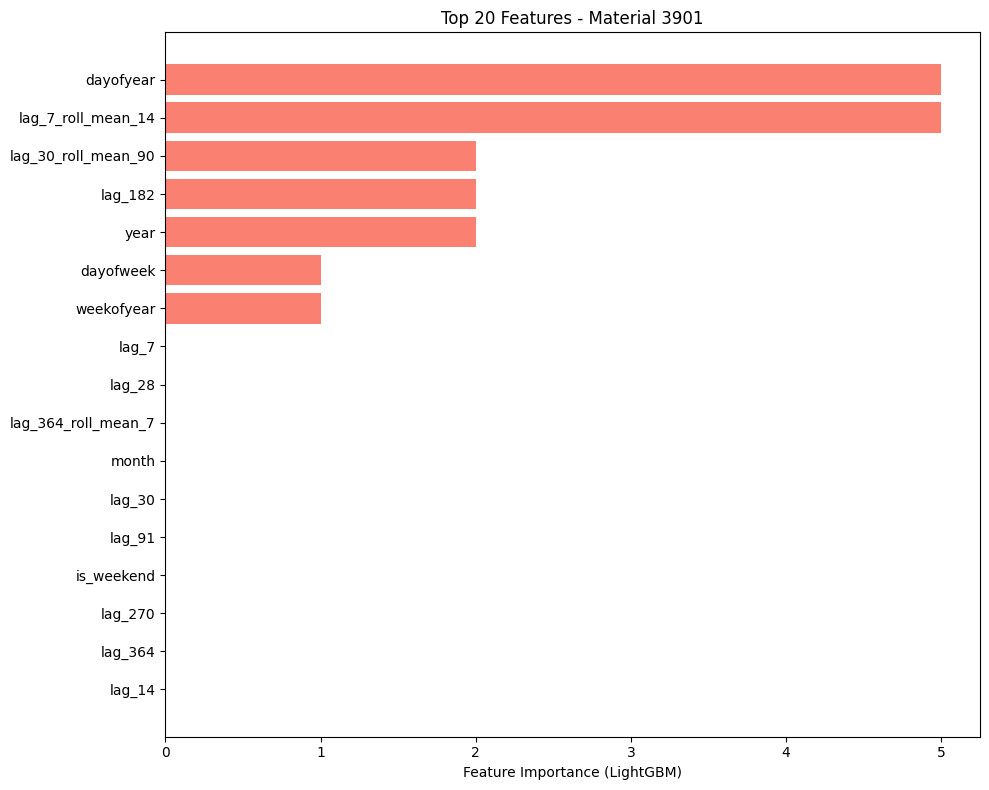

In [ ]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================

# Select material for feature importance analysis
RM_ID_FOR_DEBUG = 3901

print("\n" + "=" * 80)
print(f"FEATURE IMPORTANCE ANALYSIS - MATERIAL {RM_ID_FOR_DEBUG}")
print("=" * 80)

if RM_ID_FOR_DEBUG in mpe_models:
    model_debug = mpe_models[RM_ID_FOR_DEBUG]
    
    # Extract feature importances from trained model
    df_importance_single = pd.DataFrame({
        'feature': mpe_features,
        'importance': model_debug.feature_importances_
    })
    
    # Sort by importance
    df_importance_single = df_importance_single.sort_values(by='importance', ascending=False)
    
    print(f"\nTop 20 most important features:")
    print(df_importance_single.head(20).to_string(index=False))
    
    # Visualize top features
    df_plot_importance = df_importance_single.head(20).sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    plt.barh(df_plot_importance['feature'], df_plot_importance['importance'], color='salmon')
    plt.xlabel("Feature Importance (LightGBM)")
    plt.title(f'Top 20 Features - Material {RM_ID_FOR_DEBUG}')
    plt.tight_layout()
    
    plot_filename = f'feature_importance_rm{RM_ID_FOR_DEBUG}.png'
    plt.savefig(plot_filename)
    print(f"\n✓ Plot saved: '{plot_filename}'")
    plt.show()
    
    print("=" * 80)
else:
    print(f"Material {RM_ID_FOR_DEBUG} not found in trained models.")
    print("This material may not have met the minimum data requirements for training.")

In [ ]:
# ============================================================================
# INPUT FEATURE ANALYSIS FOR PROBLEMATIC PREDICTIONS
# ============================================================================

RM_ID_FOR_DEBUG = 3901

print("\n" + "=" * 80)
print(f"INPUT FEATURE ANALYSIS - MATERIAL {RM_ID_FOR_DEBUG}")
print("=" * 80)

if 'df_valid_results_mpe' in locals() and not df_valid_results_mpe.empty:
    
    # Filter validation results for target material
    df_debug_rm = df_valid_results_mpe[df_valid_results_mpe['rm_id'] == RM_ID_FOR_DEBUG].copy()
    
    if df_debug_rm.empty:
        print(f"No validation results found for material {RM_ID_FOR_DEBUG}.")
    else:
        # Calculate daily prediction error
        df_debug_rm['daily_error'] = df_debug_rm['net_weight'] - df_debug_rm['y_pred_daily']
        
        # Identify days with largest underestimation (positive error)
        df_debug_rm_worst_days = df_debug_rm.sort_values(by='daily_error', ascending=False).head(10)
        
        print(f"\nTop 10 days with largest UNDERESTIMATION:")
        print(df_debug_rm_worst_days[['date', 'net_weight', 'y_pred_daily', 'daily_error']].to_string(index=False))
        
        # Retrieve feature importance for this material
        if RM_ID_FOR_DEBUG in mpe_models:
            model_debug = mpe_models[RM_ID_FOR_DEBUG]
            df_importance_single = pd.DataFrame({
                'feature': mpe_features,
                'importance': model_debug.feature_importances_
            }).sort_values(by='importance', ascending=False)
            
            top_features = df_importance_single['feature'].head(10).tolist()
            
            print(f"\nFeature values on worst prediction days:")
            
            # Get input features for those days
            df_input_features = df_master_mpe[
                (df_master_mpe['rm_id'] == RM_ID_FOR_DEBUG) &
                (df_master_mpe['date'].isin(df_debug_rm_worst_days['date']))
            ]
            
            # Display relevant columns
            columns_to_show = ['date'] + top_features
            print(df_input_features[columns_to_show].round(2).to_string(index=False))
        else:
            print(f"Model for material {RM_ID_FOR_DEBUG} not found.")
    
    print("=" * 80)
else:
    print("Validation results not available for analysis.")


INPUT FEATURE ANALYSIS - MATERIAL 3901

Top 10 days with largest UNDERESTIMATION:
      date  net_weight  y_pred_daily  daily_error
2024-10-25     47940.0           0.0      47940.0
2024-11-12     42920.0           0.0      42920.0
2024-10-18     42880.0           0.0      42880.0
2024-10-08     40800.0           0.0      40800.0
2024-09-23     40620.0           0.0      40620.0
2024-11-19     40460.0           0.0      40460.0
2024-10-11     40380.0           0.0      40380.0
2024-12-16     39180.0           0.0      39180.0
2024-10-14     38280.0           0.0      38280.0
2024-10-28     36760.0           0.0      36760.0

Feature values on worst prediction days:
      date  dayofyear  lag_7_roll_mean_14  lag_30_roll_mean_90  lag_182  year  dayofweek  weekofyear   lag_7  lag_14  month
2024-09-23        267             8158.57              3990.56  24300.0  2024          0          39     0.0 15740.0      9
2024-10-08        282             6427.14              3633.67  15840.0  2024

In [ ]:
# ============================================================================
# FINAL STATISTICS
# ============================================================================

# Calculate summary statistics for submission
mean_prediction = df_submission['predicted_weight'].mean()
median_prediction = df_submission['predicted_weight'].median()
total_prediction = df_submission['predicted_weight'].sum()
non_zero_count = (df_submission['predicted_weight'] > 0).sum()

print("\n" + "=" * 80)
print("SUBMISSION STATISTICS")
print("=" * 80)
print(f"Total predictions:           {len(df_submission):,}")
print(f"Non-zero predictions:        {non_zero_count:,} ({non_zero_count/len(df_submission)*100:.1f}%)")
print(f"Mean predicted weight:       {mean_prediction:.2f} kg")
print(f"Median predicted weight:     {median_prediction:.2f} kg")
print(f"Total predicted weight:      {total_prediction:,.2f} kg")
print("=" * 80)


SUBMISSION STATISTICS
Total predictions:           30,450
Non-zero predictions:        2,827 (9.3%)
Mean predicted weight:       46004.99 kg
Median predicted weight:     0.00 kg
Total predicted weight:      1,400,851,961.71 kg
